
# 주제 : Seq2Seq의 Encoder로 뉴스기사 토픽 예측하기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제는 뉴스기사 데이터는 reuters Dataset을 사용합니다.
    - reuters Dataset은 11,228개의 뉴스기사와 46개의 주제를 가지고 있습니다.
    - 모든 단어는 빈도에 따른 정수로 교체 되어있습니다.
    - 관례적으로 정수 0은 특정 단어를 나타내는 것으로 사용하지 않습니다.
    - 학습 데이터와 정답 데이터는, 각각의 아래와 같습니다.
    
    1. train_text
      [
        [1,20, 432, 12, 312, ...],
        [42, 21, 111, 1213, ...],
        ...
      ]
    
    2. train_answer
      [
         3,  4,  3, ..., 25,  3
      ]

    
- 데이터 출처: [reuters](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection)


## 최종 목표
    - Seq2Seq 기반 모델의 이해
    - word embedding 이해
    - 시계열 데이터 학습 이해
    
  - 출제자 : 손근영 강사


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. reuters 데이터 살펴보기

In [4]:
# 데이터를 불러오는 코드를 작성해주세요.

reuters = keras.datasets.reuters
(train_text, train_topic), (test_text, test_topic) = reuters.load_data()


### 문제 2. train_text/topic와 test_text/topic의 shape을 출력해보세요.

In [5]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
print(train_text.shape, train_topic.shape)
print(test_text.shape, test_topic.shape)

(8982,) (8982,)
(2246,) (2246,)


In [6]:
# train_text/topic의 dtype을 출력해보세요.

print(train_text.dtype, train_topic.dtype)
print(test_text.dtype, test_topic.dtype)

object int64
object int64


### 문제 3. train_text에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.

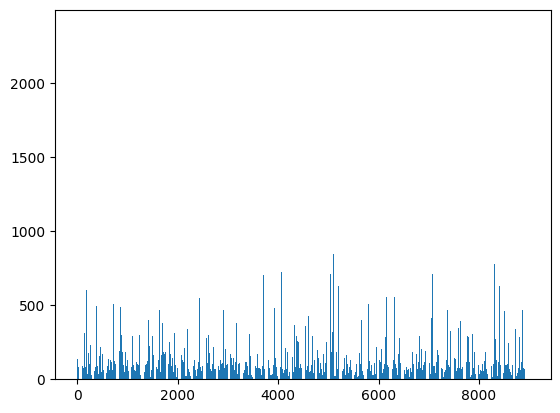

In [7]:
# train_text에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.

plt.bar(range(len(train_text)),[len(text) for text in train_text])
plt.show()

## Step 2. 전처리

### 문제 4. train_text, test_text에서 등장한 정수들을 알아보자

In [8]:
# train_text, test_text에서 등장한 정수들을 알아보자

all_words = set([word for text in train_text for word in text]) | set([word for text in test_text for word in text])
print(sorted(all_words)[:5])
print(sorted(all_words)[-5:])

[1, 2, 4, 5, 6]
[30977, 30978, 30979, 30980, 30981]


### 문제 5. train_text와 test_text를 BOW 형태로 변경

In [9]:
# train_text와 test_text를 BOW 형태로 변경하세요.
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, value = 0)
test_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, value = 0)

In [10]:
(train_bow_text.shape, test_bow_text.shape)

((8982, 2376), (2246, 1032))

### 문제 6. train과 test에 나온 word들의 count를 측정해보자

In [11]:
# train과 test에 나온 word들의 count를 측정해보자\

import collections
word_count = collections.Counter()
for text in train_text:
    word_count.update(text)
for text in test_text:
    word_count.update(text)

word_count.most_common(10)

[(4, 82723),
 (5, 42393),
 (6, 40350),
 (7, 33157),
 (8, 29978),
 (9, 29956),
 (10, 29581),
 (11, 20141),
 (12, 16668),
 (13, 15224)]

### 문제 7. word_count를 이용해서 n번 이하로 나온 word를 삭제하여 train과 test를 구성하여보자.

In [13]:
# word_count를 이용해서 n번 미만으로 나온 word를 삭제하여 train과 test를 구성하여보자.
def cut_by_count(texts, n):
    return np.array([[word for word in text if word_count[word] >= n] for text in texts], dtype=object)

train_cut_text = cut_by_count(train_text, 20)
test_cut_text = cut_by_count(test_text, 20)

print(train_cut_text.shape)
print(test_cut_text.shape)


(8982,)
(2246,)


### 문제 8. pad 추가된 bow 형태로 변화하여 width 길이를 확인해보세요.

In [14]:
# bow 형태로 변화하여 width 길이를 확인해보세요.

train_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, value=0)
test_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, value=0)

In [15]:
train_cut_bow_text.shape, test_cut_bow_text.shape

((8982, 2266), (2246, 995))

### 문제 9. train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.

In [20]:
# train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.

train_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(train_text, value = 0, maxlen = 200)
test_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(test_text, value = 0, maxlen = 200)


In [21]:
train_cut_bow_text2.shape, test_cut_bow_text2.shape

((8982, 200), (2246, 200))

### 문제 10. topic을 onehot encoding으로 변경해보세요.

In [26]:
# topic을 onehot encoding으로 변경해보세요.
np.unique(train_topic)

train_onehot_topic = keras.utils.to_categorical(train_topic)
test_onehot_topic = keras.utils.to_categorical(test_topic)

print(train_onehot_topic.shape, test_onehot_topic.shape)

(8982, 46) (2246, 46)


### 문제 11. topic 인덱스를 text label로 변환하는 함수를 만드세요.

In [28]:
#topic 인덱스를 text label로 변환하는 함수를 만드세요.
raw_labels = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

def topic2label(idx):
   return raw_labels[idx]

print(topic2label(0))
print(topic2label(45))

cocoa
lead


## Step 3. 시각화 방법

### 문제 12. train_text의 길이 분포를 출력해보세요.

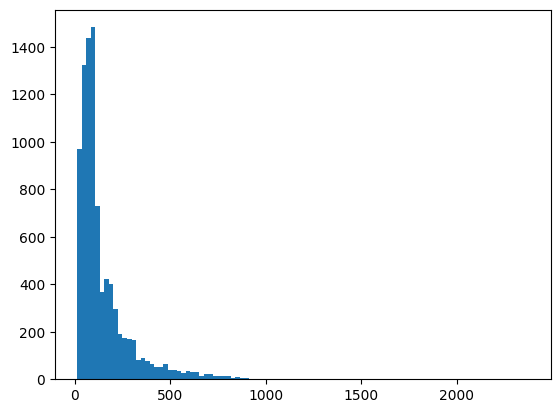

In [47]:
# train_bow_text의 길이 분포를 출력해보세요.

# bins : 해상도
plt.hist([len (s) for s in train_text], bins=100) # 문장 길이가 짧은 애들이 많다
plt.show()

### 문제 13. train_cut_bow_text의 길이 분포를 출력해보세요.

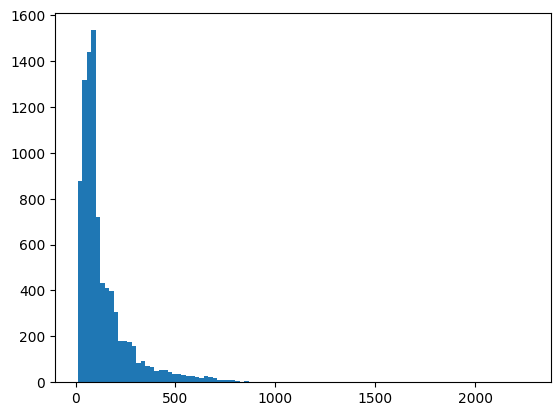

In [48]:
# train_bow_text의 길이 분포를 출력해보세요.

plt.hist([len(s) for s in train_cut_text], bins=100)
plt.show()


### 문제 14. train_cut_bow_text2의 길이 분포를 출력해보세요.

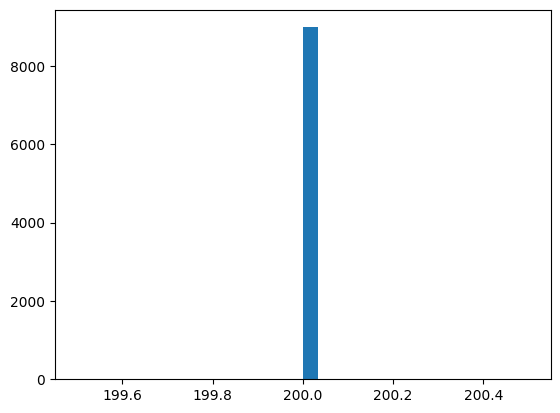

(8982, 200)

In [50]:
# train_cut_bow_text2의 길이 분포를 출력해보세요.

plt.hist([len(s) for s in train_cut_bow_text2], bins = 30)
plt.show()

train_cut_bow_text2.shape

### 문제 15. label 분포를 출력해보세요.

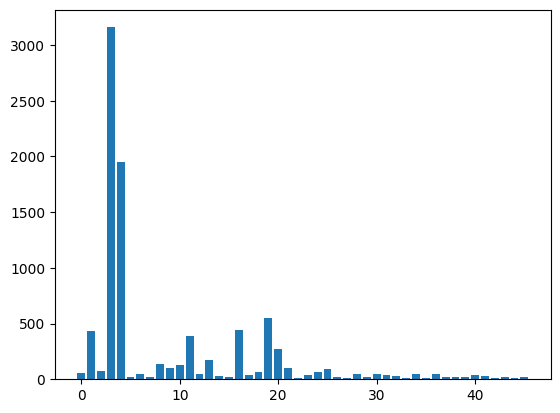

In [54]:
# label 분포를 출력해보세요.
import collections

plt.bar(np.unique(train_topic), list(map(lambda x:x[1], sorted(collections.Counter(train_topic).items()))))
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]), array([  55,  432,   74, 3159, 1949,   17,   48,   16,  139,  101,  124,
        390,   49,  172,   26,   20,  444,   39,   66,  549,  269,  100,
         15,   41,   62,   92,   24,   15,   48,   19,   45,   39,   32,
         11,   50,   10,   49,   19,   19,   24,   36,   30,   13,   21,
         12,   18]))
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45] [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
   26   20  444   39   66  549  269  100   15   41   62   92   24   15
   48   19   45   39   32   11   50   10   49   19   19   24   36   30
   13   21   12   18]


<BarContainer object of 46 artists>

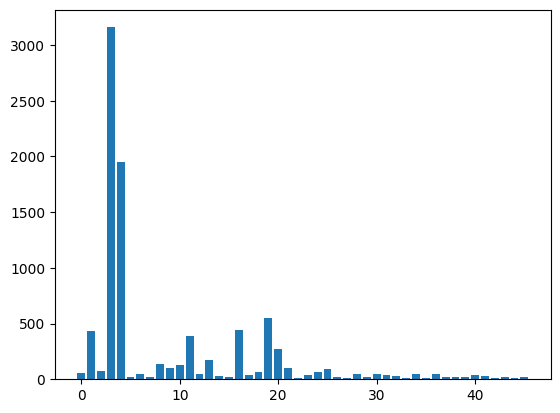

In [58]:
print(np.unique(train_topic, return_counts=True))
print(*np.unique(train_topic, return_counts=True))
plt.bar(*np.unique(train_topic, return_counts=True))

### 문제 16. seabon을 이용하여 label 분포를 출력해보세요.

<Axes: ylabel='count'>

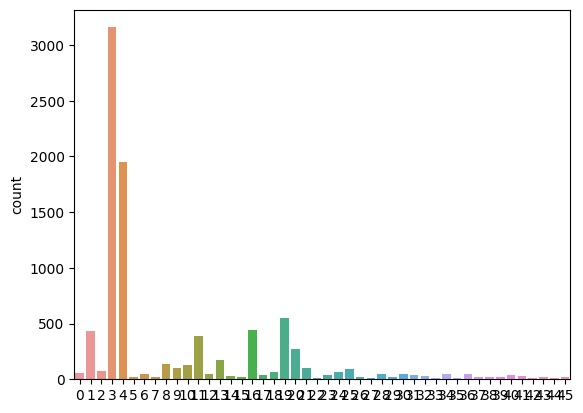

In [70]:
# label 분포를 출력해보세요.

sns.countplot(x=train_topic)

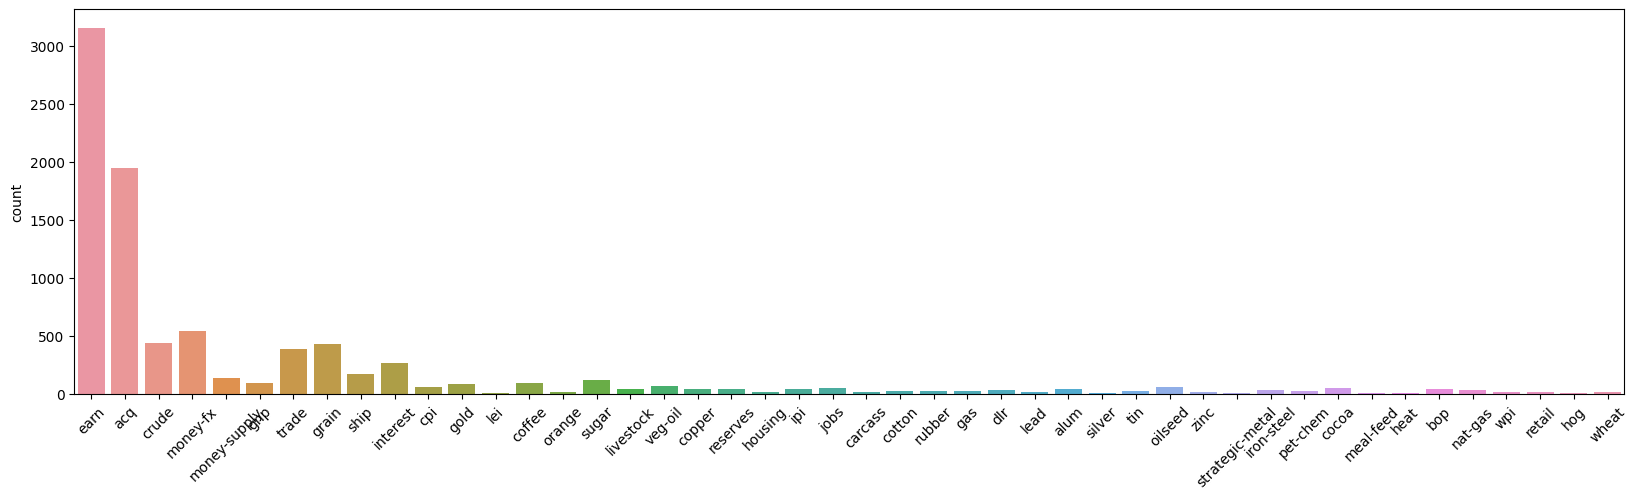

In [76]:

sns.countplot(x = list(map(lambda x: topic2label(x), train_topic)))
plt.xticks(rotation = 45)
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.show()

### 문제 17. reuters.get_word_index()를 이용해서 text를 decode해보세요.

In [81]:
# reuters.get_word_index()를 이용해서 text를 decode해보세요.

index_word = {y : x for x, y in reuters.get_word_index().items()}

def bow2text(bow):
    return " ".join([index_word[idx] for idx in bow])

bow2text(test_text[0])

'the in wants intermediate 3 how types could mln at against 2 guidelines vs end products opec he will will along results and willingly exports 3 purchased each it stubbornly profit 3 avondale profit agreement in around corp should for 3 cannot mln in ended said avondale a 54 but 3 stubbornly a only generally political primarily date other under well a in british rate gain if demand at an div its taking report montreal systems were is and production had vs 000 7 issued year for 0 a in buffer rate loss may results tariffs dlrs is and from 39 s 000 for 3 cannot pre 50 east that in foods products opec last 1 fall change 1 approval in 15 2 said in opec 28 but for 3 cannot cts systems which is half be 6 iffezheim uobm said president amount pct dlrs'

### 문제 18. train/test 데이터에서 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.

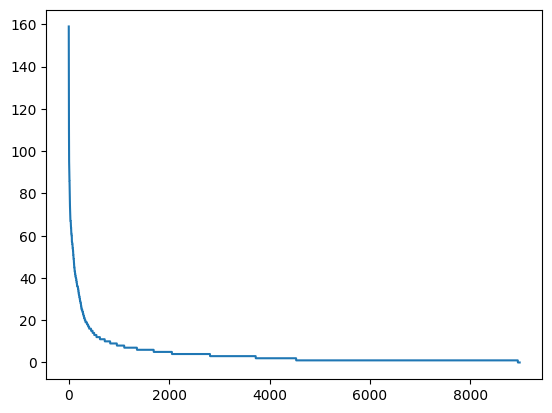

In [84]:
# 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.
plt.plot(sorted([np.unique(doc, return_counts=True)[1].argmax() for doc in train_text], reverse=True))
plt.show()


### 문제 19. train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력하세요.

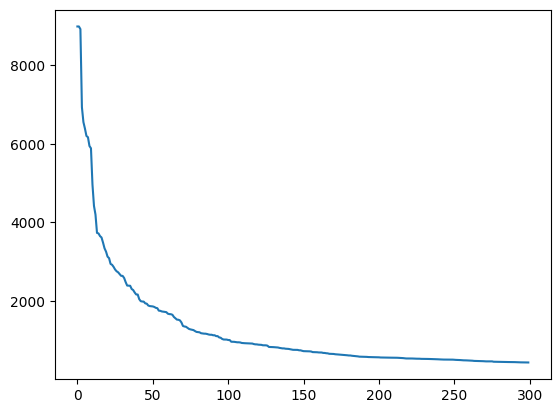

In [87]:
# train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력하세요.

table = np.zeros(len(all_words) + 2)

for doc in train_text:
    table[np.unique(doc)] += 1

plt.plot(sorted(table, reverse=True)[:300])

## Step 4. Seq2Seq의 Encoder 이용 모델링

### 문제 20. Encoder이용 classification 모델 구축

In [92]:
# seq2seq 모델을 구축하고 학습모델, encoder를 획득하세요
from keras.layers import Input, GRU, Embedding, Dense
from keras.models import Model

def seq2seq():
    inputs_x_bow = Input(shape = (200, ))
    x = Embedding(len(index_word) + 1, 120)(inputs_x_bow)
    context_vector = GRU(units = 64)(x)

    y = Dense(units = 46, activation = 'softmax')(context_vector)

    model = Model(inputs_x_bow, y)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model




### 문제 21. 학습 모델을 생성하고 summary를 출력하세요. 

In [93]:
# 학습 모델을 생성하고 summary를 출력하세요.
model = seq2seq()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 120)          3717600   
                                                                 
 gru (GRU)                   (None, 64)                35712     
                                                                 
 dense (Dense)               (None, 46)                2990      
                                                                 
Total params: 3756302 (14.33 MB)
Trainable params: 3756302 (14.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 문제 22. 모델을 학습해보세요.

In [95]:
# 학습모델을 학습해보세요.

hist = model.fit(
    train_cut_bow_text2, train_onehot_topic,
    validation_data = (
        test_cut_bow_text2,
        test_onehot_topic
    ),
    epochs = 20,
    verbose = 1
)

Epoch 1/20


2023-10-30 17:14:21.801564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 17:14:21.943578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 17:14:22.511834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - ETA: 0s - loss: 2.1558 - accuracy: 0.4332

2023-10-30 17:14:36.110632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 17:14:36.170039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 16s 53ms/step - loss: 2.1558 - accuracy: 0.4332 - val_loss: 1.7344 - val_accuracy: 0.5423
Epoch 2/20
281/281 [==============================] - 13s 47ms/step - loss: 1.6332 - accuracy: 0.5698 - val_loss: 1.6793 - val_accuracy: 0.5819
Epoch 3/20
281/281 [==============================] - 13s 47ms/step - loss: 1.4711 - accuracy: 0.6172 - val_loss: 1.6377 - val_accuracy: 0.5886
Epoch 4/20
281/281 [==============================] - 13s 46ms/step - loss: 1.3235 - accuracy: 0.6499 - val_loss: 1.5763 - val_accuracy: 0.6073
Epoch 5/20
281/281 [==============================] - 13s 46ms/step - loss: 1.1546 - accuracy: 0.6910 - val_loss: 1.6062 - val_accuracy: 0.6015
Epoch 6/20
281/281 [==============================] - 13s 46ms/step - loss: 1.0007 - accuracy: 0.7364 - val_loss: 1.5673 - val_accuracy: 0.6189
Epoch 7/20
281/281 [==============================] - 13s 47ms/step - loss: 0.8766 - accuracy: 0.7764 - val_loss: 1.5876 - val_accuracy: 0.6349
Epo

### 문제 23. 학습 진행 사항을 plt으로 출력하세요.

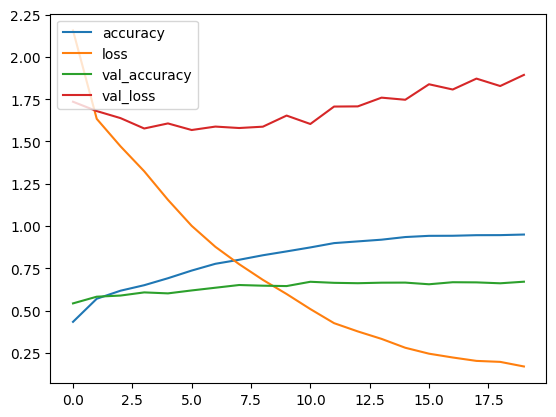

In [96]:
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요.

plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper left')
plt.show()


### 문제 24. train_cut_bow_text를 위한 학습 모델을 생성하고 summary를 출력하세요. 

In [99]:
# 학습 모델을 생성하고 summary를 출력하세요.

model2 = seq2seq()
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 120)          3717600   
                                                                 
 gru_1 (GRU)                 (None, 64)                35712     
                                                                 
 dense_1 (Dense)             (None, 46)                2990      
                                                                 
Total params: 3756302 (14.33 MB)
Trainable params: 3756302 (14.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 문제 25. 학습모델을 학습해보세요. 단, train_cut_bow_text를 200으로 길이를 수정하고 실행하세요.

In [100]:
# 학습모델을 학습해보세요.
train_cut_bow_text.shape, test_cut_bow_text.shape

((8982, 2266), (2246, 995))

In [101]:
train_cut_bow_text[..., -200:].shape

(8982, 200)

In [102]:
hist2 = model2.fit(
    train_cut_bow_text[..., -200:], 
    train_onehot_topic,
    
    validation_data = (
        test_cut_bow_text[..., -200:],
        test_onehot_topic),
    
    epochs = 20,
    verbose = 1
)

Epoch 1/20


2023-10-30 17:23:14.345939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 17:23:14.495459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 17:23:14.668007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - ETA: 0s - loss: 2.1775 - accuracy: 0.4186

2023-10-30 17:23:28.408629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 17:23:28.474167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 16s 54ms/step - loss: 2.1775 - accuracy: 0.4186 - val_loss: 1.7993 - val_accuracy: 0.5236
Epoch 2/20
281/281 [==============================] - 14s 51ms/step - loss: 1.6505 - accuracy: 0.5699 - val_loss: 1.6861 - val_accuracy: 0.5770
Epoch 3/20
281/281 [==============================] - 13s 48ms/step - loss: 1.4824 - accuracy: 0.6224 - val_loss: 1.5703 - val_accuracy: 0.6109
Epoch 4/20
281/281 [==============================] - 13s 48ms/step - loss: 1.3011 - accuracy: 0.6643 - val_loss: 1.4878 - val_accuracy: 0.6162
Epoch 5/20
281/281 [==============================] - 13s 48ms/step - loss: 1.1515 - accuracy: 0.7035 - val_loss: 1.4375 - val_accuracy: 0.6327
Epoch 6/20
281/281 [==============================] - 14s 48ms/step - loss: 1.0271 - accuracy: 0.7349 - val_loss: 1.4317 - val_accuracy: 0.6500
Epoch 7/20
281/281 [==============================] - 13s 47ms/step - loss: 0.9108 - accuracy: 0.7689 - val_loss: 1.4014 - val_accuracy: 0.6692
Epo

### 문제 26. 학습 진행 사항을 plt으로 출력하세요.

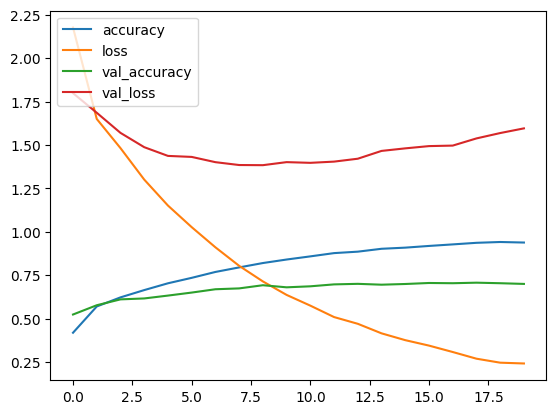

In [103]:
# hist2의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요.

plt.plot(hist2.history['accuracy'], label = 'accuracy')
plt.plot(hist2.history['loss'], label = 'loss')
plt.plot(hist2.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist2.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper left')
plt.show()

## Step 5. 모델 결과 확인

### 문제 27. 완성된 모델1, 2에서 test 하나를 예측하고 결과를 res1, res2 변수에 저정하세요.

In [121]:
# 완성된 모델에서 test 하나를 예측하고 결과를 res 변수에 저정하세요.

res1 = model.predict(test_cut_bow_text2[1:2])
res1, res1.shape

1/1 [==============================] - 0s 18ms/step


(array([[7.15570233e-04, 7.67317653e-01, 8.78179818e-02, 1.75092905e-03,
         3.54342610e-02, 1.57241491e-04, 5.02176363e-07, 8.17990440e-06,
         1.18365426e-06, 1.05903734e-06, 5.33398315e-02, 8.67568364e-04,
         2.93910671e-06, 1.06296958e-02, 1.11178926e-03, 3.58902616e-04,
         2.58332887e-03, 1.57699396e-04, 8.81308733e-06, 6.76817028e-03,
         7.11472530e-04, 1.20023260e-05, 3.05561186e-03, 1.31594054e-02,
         8.63317458e-04, 8.61918496e-04, 3.42062322e-06, 1.35151902e-06,
         1.19640594e-04, 2.84469043e-05, 2.51605456e-06, 4.76869667e-04,
         8.29209910e-07, 9.09823575e-05, 4.05417602e-08, 3.83053657e-06,
         3.53010961e-07, 8.46295188e-06, 2.81926943e-04, 7.06372111e-06,
         4.69029364e-05, 1.12196123e-02, 9.00738178e-06, 1.11770271e-06,
         2.09802323e-07, 4.36866259e-07]], dtype=float32),
 (1, 46))

In [122]:
res2 = model2.predict(test_cut_bow_text[1:2, -200:])
res2, res2.shape

1/1 [==============================] - 0s 18ms/step


(array([[3.5375052e-03, 7.5238757e-04, 3.0935043e-06, 4.9796385e-05,
         3.4641117e-04, 1.7736638e-04, 9.0129249e-04, 2.4907871e-05,
         7.9451786e-07, 1.5254975e-05, 9.8271322e-01, 5.8001967e-07,
         6.9674413e-09, 5.4893399e-06, 9.1234979e-06, 2.8416715e-03,
         1.4831137e-06, 1.9020932e-05, 1.2712734e-07, 1.6174353e-07,
         3.2190783e-07, 1.8160471e-06, 7.5525494e-04, 1.1941860e-03,
         1.2155995e-05, 5.5069482e-04, 1.9698140e-04, 1.7692274e-06,
         7.7134726e-04, 2.7833923e-05, 6.5084664e-06, 1.1878207e-05,
         1.5562894e-04, 1.3454690e-05, 1.7553630e-05, 5.3890067e-06,
         4.9810581e-07, 2.4978915e-04, 1.0955364e-03, 9.0399677e-05,
         2.6757320e-08, 1.2643334e-05, 3.3387667e-03, 1.1193699e-06,
         1.0728948e-05, 7.8095218e-05]], dtype=float32),
 (1, 46))

### 문제 28. res1, res2의 결과를 확인하세요.

'sugar'

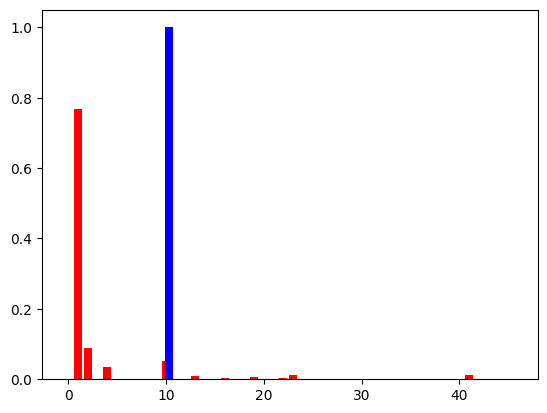

In [126]:
# res1, res2의 결과를 확인하세요.

plt.bar(np.array(range(len(res1[0]))), res1[0], color = 'red')
plt.bar(np.array(range(len(res1[0]))) + 0.3, test_onehot_topic[1], color = 'blue')

topic2label(test_onehot_topic[1].argmax())

'sugar'

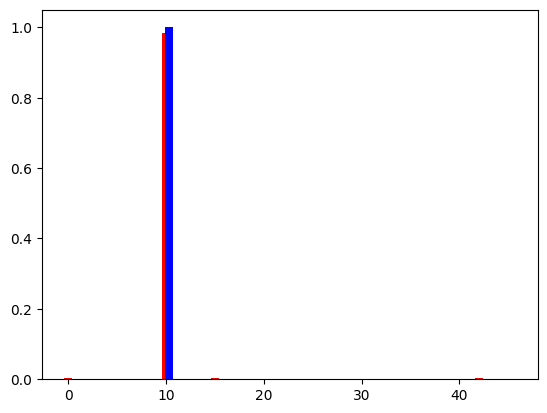

In [125]:
plt.bar(np.array(range(len(res2[0]))), res2[0], color = 'red')
plt.bar(np.array(range(len(res2[0]))) + 0.3, test_onehot_topic[1], color = 'blue')

topic2label(test_onehot_topic[1].argmax())

1/1 [==============================] - 0s 35ms/step


'sugar'

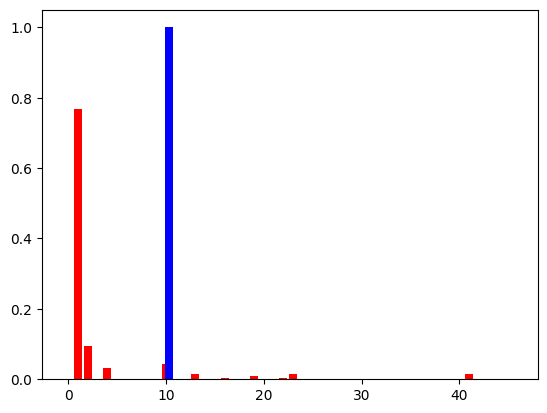

In [130]:
 

worng1 = model.predict(test_cut_bow_text[1:2, -200:])

plt.bar(np.array(range(len(worng1[0]))), worng1[0], color = 'red')
plt.bar(np.array(range(len(worng1[0]))) + 0.3, test_onehot_topic[1], color = 'blue')

topic2label(test_onehot_topic[1].argmax())

1/1 [==============================] - 0s 24ms/step


'sugar'

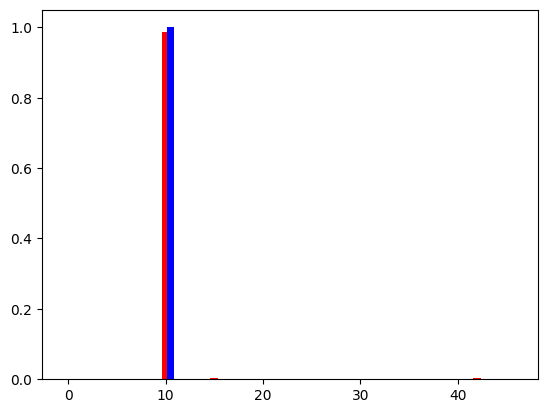

In [131]:
wrong2 = model2.predict(test_cut_bow_text2[1:2])

plt.bar( np.array(range(len(wrong2[0]))),  wrong2[0],     color="red" )
plt.bar( np.array(range(len(wrong2[0]))) + 0.5,  test_onehot_topic[1],     color="blue" )

topic2label( test_onehot_topic[1].argmax() ) 

### 문제 29. reuters.get_word_index()를 이용하여 평문을 bow로 변환해보세요. 

In [132]:
# reuters.get_word_index()를 이용하여 평문을 bow로 변환해보세요. (oov는 무시합니다.)
# oov = out of vocab
text = bow2text(test_text[0])
text

'the in wants intermediate 3 how types could mln at against 2 guidelines vs end products opec he will will along results and willingly exports 3 purchased each it stubbornly profit 3 avondale profit agreement in around corp should for 3 cannot mln in ended said avondale a 54 but 3 stubbornly a only generally political primarily date other under well a in british rate gain if demand at an div its taking report montreal systems were is and production had vs 000 7 issued year for 0 a in buffer rate loss may results tariffs dlrs is and from 39 s 000 for 3 cannot pre 50 east that in foods products opec last 1 fall change 1 approval in 15 2 said in opec 28 but for 3 cannot cts systems which is half be 6 iffezheim uobm said president amount pct dlrs'

### 문제 30. text2bow를 이용하여 model1을 통해 결과를 확인하세요.

In [142]:
# text2bow를 이용하여 model1을 통해 결과를 확인하세요.

def text2bow(text, maxlen = 400):
    word_index = reuters.get_word_index()
    
    seq = np.array([word_index[word] for word in text.lower().replace('\n', ' ').split() if word in word])

    bow = tf.keras.preprocessing.sequence.pad_sequences([seq], value = 0, maxlen = maxlen)
    return bow


In [143]:
bow1 = text2bow(text)
bow1.shape

(1, 400)

In [144]:
bow1

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

1/1 [==============================] - 0s 83ms/step


<BarContainer object of 46 artists>

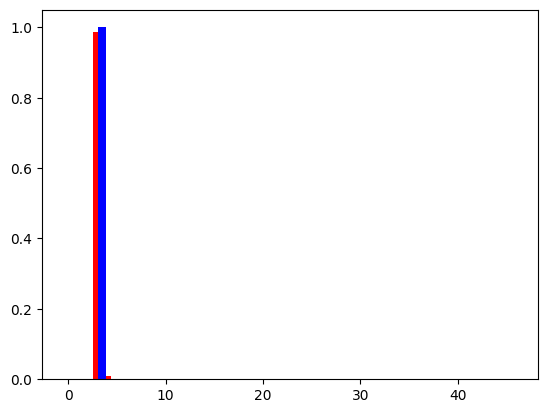

In [150]:
res3 = model.predict(bow1[..., -200:])
plt.bar(np.array(range(len(res3[0]))), res3[0], color = 'red')
plt.bar(np.array(range(len(res3[0]))) + 0.5, test_onehot_topic[0], color = 'blue')

### 문제 31. cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요

In [151]:
# cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요

bow1_cut = tf.keras.preprocessing.sequence.pad_sequences(cut_by_count(bow1, 20), maxlen=200)
bow1_cut

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1,    4, 1378, 2025,
           9,  697, 4622,  111,    8,   25,  109,   29, 3650,   11,  150,
         244,  364,   33,   30,   30, 1398,  333,    6,  159,    9, 1084,
         363,   13,   71,    9,   71,  117,    4,  225,   78,  206,   10,
           9, 1214,    8,    4,  270,    5,    7,  748,   48,    9,    7,
         207, 1451,  966, 1864,  793,   97,  133,  336,    7,    4,  493,
          98,  273,  104,  284,   25,   39,  338,   22,  905,  220, 3465,
         644,   59,   20,    6,  119,   61,   11,   15,   58,  579,   26,
          10,   67,    7,    4,  738, 

In [152]:
cut_by_count(bow1, 20)

array([[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11,
        150, 244, 364, 33, 30, 30, 1398, 333, 6, 159, 9, 1084, 363, 13,
        71, 9, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 7,
        748, 48, 9, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4,
        493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59,
        20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43,
        88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129,
        783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29,
        5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 5,
        192, 510, 17, 12]], dtype=object)

### 문제 32. text2bow를 이용하여 model1을 통해 결과를 확인하세요.


1/1 [==============================] - 0s 29ms/step


<BarContainer object of 46 artists>

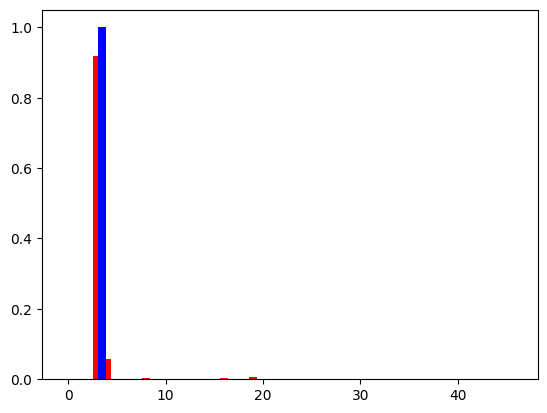

In [154]:
#text2bow를 이용하여 model1을 통해 결과를 확인하세요.
res4 = model2.predict(bow1_cut)
plt.bar(np.array(range(len(res4[0]))), res4[0], color = 'red')
plt.bar(np.array(range(len(res4[0])))+ 0.5, test_onehot_topic[0], color = 'blue')

### 문제 33. confusion 매트릭스 생성

In [161]:
# confusion 메트릭스 출력

from sklearn.metrics import confusion_matrix

conf_mat1 = confusion_matrix(test_onehot_topic.argmax(axis = 1), model.predict(test_cut_bow_text2).argmax(axis = 1))
print(conf_mat1, conf_mat1.shape)



71/71 [==============================] - 1s 13ms/step
[[ 5  1  0 ...  0  0  0]
 [ 0 71  2 ...  1  0  0]
 [ 0  3  4 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]] (46, 46)


In [162]:

conf_mat2 = confusion_matrix(test_onehot_topic.argmax(axis = 1), model2.predict(test_cut_bow_text[..., -200:]).argmax(axis = 1))
print(conf_mat1, conf_mat1.shape)

71/71 [==============================] - 1s 15ms/step
[[ 5  1  0 ...  0  0  0]
 [ 0 71  2 ...  1  0  0]
 [ 0  3  4 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]] (46, 46)


### 문제 34. confusion 매트릭스 시각화

<Axes: >

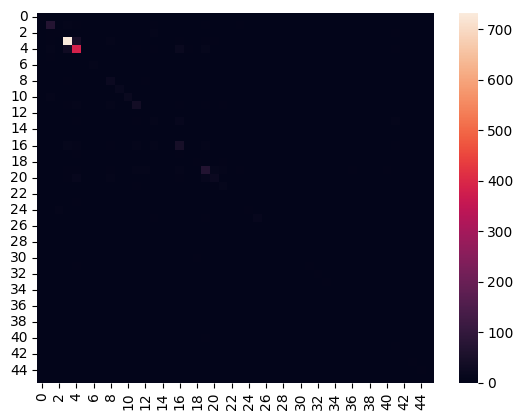

In [163]:
# confusion 매트릭스 시각화

sns.heatmap(conf_mat1)

<Axes: >

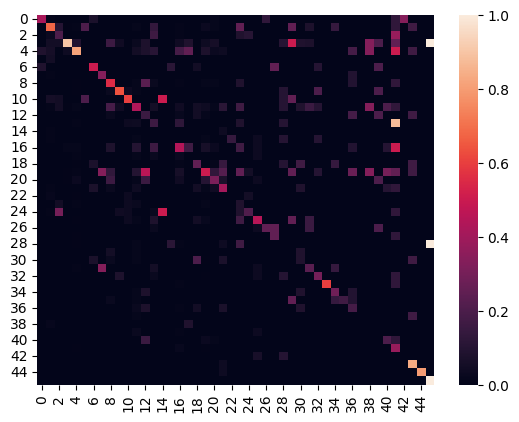

In [165]:
sns.heatmap(conf_mat1 / conf_mat1.sum(axis = 1) )

<Axes: >

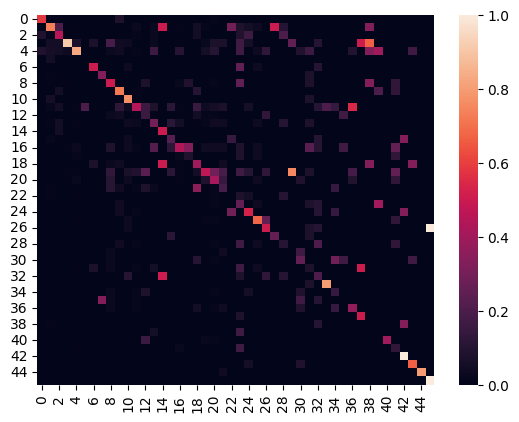

In [166]:
sns.heatmap(conf_mat2 / conf_mat2.sum(axis = 1) )

### 문제 35. classification 결과 리포팅

In [170]:
# classification 결과 리포팅

from sklearn.metrics import classification_report

print(classification_report(test_onehot_topic.argmax(axis = 1), model.predict(test_cut_bow_text2).argmax(axis = 1)))



71/71 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.66      0.68      0.67       105
           2       0.25      0.20      0.22        20
           3       0.92      0.90      0.91       813
           4       0.76      0.81      0.79       474
           5       0.00      0.00      0.00         5
           6       0.64      0.50      0.56        14
           7       0.33      0.33      0.33         3
           8       0.38      0.55      0.45        38
           9       0.76      0.64      0.70        25
          10       0.75      0.60      0.67        30
          11       0.43      0.43      0.43        83
          12       0.11      0.15      0.12        13
          13       0.15      0.16      0.16        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.41    

In [171]:
# classification 결과 리포팅

from sklearn.metrics import classification_report

print(classification_report(test_onehot_topic.argmax(axis = 1), model2.predict(test_cut_bow_text[..., -200:]).argmax(axis = 1), target_names=raw_labels))



71/71 [==============================] - 1s 11ms/step
                 precision    recall  f1-score   support

          cocoa       0.78      0.58      0.67        12
          grain       0.70      0.73      0.72       105
        veg-oil       0.47      0.45      0.46        20
           earn       0.91      0.91      0.91       813
            acq       0.80      0.83      0.81       474
          wheat       0.00      0.00      0.00         5
         copper       0.70      0.50      0.58        14
        housing       0.50      0.33      0.40         3
   money-supply       0.37      0.50      0.43        38
         coffee       0.58      0.72      0.64        25
          sugar       0.62      0.77      0.69        30
          trade       0.62      0.45      0.52        83
       reserves       0.17      0.15      0.16        13
           ship       0.31      0.30      0.30        37
         cotton       0.25      0.50      0.33         2
        carcass       0.29      0

## Step 6. 모델 저장 및 로드, 다운

### 문제 36. 모델을 저장하세요.

In [172]:
# 모델을 저장하는 코드를 작성하세요. 

model.save('./part3_ch2_model.h5')


### 문제 37. 모델 파일을 새로운 모델에 로드하세요.

In [173]:
# 모델을 로드하는 코드를 작성하세요.

new_model = tf.keras.models.load_model('./part3_ch2_model.h5')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 120)          3717600   
                                                                 
 gru (GRU)                   (None, 64)                35712     
                                                                 
 dense (Dense)               (None, 46)                2990      
                                                                 
Total params: 3756302 (14.33 MB)
Trainable params: 3756302 (14.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 문제 38. 로드한 모델을 test 데이터로 평가해보세요.


In [174]:
# 로드한 모델을 test 데이터로 평가해보세요.

loss, acc = new_model.evaluate(test_cut_bow_text2, test_onehot_topic, verbose = 1)
print(loss, acc)

2023-10-30 18:00:49.443257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-30 18:00:49.514406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 2s 23ms/step - loss: 1.8931 - accuracy: 0.6705
1.8931210041046143 0.6705253720283508


### 문제 39. 모델을 내 컴퓨터에 저장해보세요

In [175]:
# 모델을 내 컴퓨터에 저장해보세요.